# Vícevrstvé sítě a zpětná propagace

V tomto cvičení si vyzkoušíme klasifikaci pomocí vícevrstvých dopředných sítí, tzv. vícevrstvých perceptronů. Pro porovnání se přitom zaměříme na stejný dataset jako minule, tedy klasifikaci CIFAR-10.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

import ans

Výchozím datovým typem v pytorchi je 32bitový `float`, který postačuje pro trénování modelů, avšak může způsobovat problémy při kontrole implementace zpětného průchodu (gradient check). Následující buňka proto mění výchozí typ na `double`, byť v praxi, zejména při použití GPU, se z důvodu úspory paměti a času pro trénování nepoužívá. Naopak se lze setkat i s nižší přesností, např. 16bitovým floating point (half-precision) či dokonce 1bitovými binárními čísly.

In [4]:
torch.set_default_dtype(torch.double)

## Načtení dat

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
trainset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [6]:
trainset.data.shape, trainset.data.dtype

((50000, 32, 32, 3), dtype('uint8'))

In [7]:
type(trainset.targets), len(trainset.targets)

(list, 50000)

In [8]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
testset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [9]:
testset.data.shape, testset.data.dtype

((10000, 32, 32, 3), dtype('uint8'))

In [10]:
type(testset.targets), len(testset.targets)

(list, 10000)

## Matice trénovacích a validačních dat

Matice **trénovacích** dat:

In [11]:
# prevedeme na pytorch tensor a dostaneme do rozsahu [0...1] (vydelime 255)
# pozn.: nastavujeme dtype explicitne, jinak PyTorch prevezme dtype z numpy pole `trainset.train_data`
X_train = torch.tensor(trainset.data, dtype=torch.get_default_dtype()) / 255.

# reshape na matici s obrazky na radcich
X_train = X_train.reshape(X_train.shape[0], -1)

X_train.dtype, X_train.shape

(torch.float64, torch.Size([50000, 3072]))

**Labely** trénovacích dat:

In [12]:
y_train = torch.tensor(trainset.targets)
y_train.dtype, y_train.shape

(torch.int64, torch.Size([50000]))

Matice **validačních** dat:

In [13]:
# prevedeme na pytorch tensor a dostaneme do rozsahu [0...1] (vydelime 255)
# pozn.: nastavujeme dtype explicitne, jinak PyTorch prevezme dtype z numpy pole `testset.test_data`
X_valid = torch.tensor(testset.data, dtype=torch.get_default_dtype()) / 255.

# reshape na matici s obrazky na radcich
X_valid = X_valid.reshape(X_valid.shape[0], -1)

X_valid.dtype, X_valid.shape

(torch.float64, torch.Size([10000, 3072]))

**Labely** validačních dat:

In [14]:
y_valid = torch.tensor(testset.targets)
y_valid.dtype, y_valid.shape

(torch.int64, torch.Size([10000]))

## Modul: lineární vrstva

Základním kamenem lineární klasifikace je lineární, či technicky vzato správně afinní operace, jejíž

**dopředný průchod** má formu:
$$s = Wx + b$$

Z uvedeného vztahu se pak odvozuje podoba gradientu na váhy a vstup při zpětné propagaci.

**Zpětný průchod**

Gradient na váhovou matici $W$
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial s} x^\top$$

Gradient na bias vektor $b$
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial s}$$

Gradient na vstup $x$
$$\frac{\partial L}{\partial x} = W^\top \frac{\partial L}{\partial s}$$

Jak jsme si ukázali v přednášce, modularizací této operace vyjádřením jako vrstvy s dopředným a zpětným průchodem je možné výpočty libovolně řetězit a kombinovat, což usnadňuje sestavení vícevrstvých hlubokých sítí.

### Modularizace

Vzor obecné vrstvy je definován v modulu `ans`. Je to třída, kde důležité je následující:
``` python
class Layer(object):

    def __init__(self):
        super().__init__()
        self.params = {}
        self._cache = None
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def backward(self, *args, **kwargs):
        raise NotImplementedError
```

Každá vrstva typu `Layer` má parametry definované slovníkem `params`, který mapuje jména parametrů na jejich hodnoty. Dále obsahuje atribut `_cache`, který ukládá hodnoty z dopředného průchodu pro efektivnější výpočet zpětného průchodu.

Modularizaci lineární vrstvy tedy provedeme tak, že ze vzoru `Layer` odvodíme třídu `Linear` a implementujeme její dvě metody, jednu pro dopředný průchod a druhou pro zpětný.
1. Dopředný průchod vrátí $s$ dle výše uvedeného vzorce a pro efektivní výpočty uloží některé proměnné do paměti (`_cache`).
2. Zpětný průchod přijme nějaký příchozí gradient ${\partial L} / {\partial s}$ (např. z nadřazené vrstvy či lossu), spočítá gradienty na svoje parametry $W$ a $b$ a vstup $x$ a vrátí k případné další propagaci výpočetním grafem.

**Pozn.:** Všechny funkce navrhneme tak, aby pracovaly s dávkami vzorků (mini-batch), nikoliv pro samostatné vektory. Změna se projeví pouze tak, že se gradienty pro každý vzorek sečtou. Pokud např.
$$ s^{(1)}=Wx^{(1)} + b $$
$$ s^{(2)}=Wx^{(2)} + b $$
tj. minibatch o délce dvou, během jejíhož výpočtu se parametry $W$ a $b$ nemění, pak výsledný gradient za celou dávku je
$$ \frac{\partial L}{\partial W} = \frac{\partial L}{\partial s^{(1)}}{x^{(1)}}^\top + \frac{\partial L}{\partial s^{(2)}}{x^{(2)}}^\top $$

In [15]:
class Linear(ans.Layer):
    
    def __init__(self, input_dim, output_dim, weight_scale=1e-3):
        """
        input_dim    ... rozmer vstupu
        output_dim   ... rozmer vystupu
        weight_scale ... muze byt `float` nebo retezec s nazvem inicializacni metody
        """
        super().__init__()
        
        #################################################################
        # ZDE DOPLNIT
        
        # pripad weight_scale == 'xavier' znamena automaticky nastavit
        # weight_scale na hodnotu zavislou na velikosti vstupu
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_scale = torch.randn(1,1)/np.sqrt(self.input_dim)
        
        # slovnik `params` drzi hodnoty parametru vrstvy, tj. napr. vahovou matici a bias
        self.params = {
            'weights': weight_scale * torch.randn(input_dim, output_dim),
            'bias': torch.zeros(output_dim)
        }
        
        #################################################################
    
    def forward(self, inputs):
        """
        dopredny pruchod linearni vrstvou

        vstup:
            inputs  ... N x D matice vstupu (minibatch o delce N)

        vystup:
            score   ... N x H vystupni linearni skore
        """
                
        #################################################################
        # ZDE DOPLNIT
        
        score = torch.matmul(inputs, self.__getattr__('weights'))+self.__getattr__('bias')
        self._cache = inputs
        
        #################################################################

        return score
    
    def backward(self, dscore):
        """
        zpetny pruchod linearni vrstvou

        vstup:
            dscore  ... N x H prichozi gradient z nadrazene vrstvy

        vystup:
            dinputs ... N x D gradient na vstup, tj. na `inputs` metody `forward`
            grads   ... slovnik mapujici jmena parametru na jejich gradienty
        """
        
        #################################################################
        # ZDE DOPLNIT
        
        # nacist cached
        cached_input = self._cache
        # spocitat gradienty
        dinputs = torch.matmul(dscore, self.params['weights'].t())
        dweights = torch.matmul(cached_input.t(), dscore)
        dbias = torch.sum(dscore, 0)
        
        ##################################################################

        return dinputs, {'weights': dweights, 'bias': dbias}

Zda si dopředný a zpětný průchod odpovídají zjistíme kontrolou získaného gradientu. Vrstvu vyzkoušíme na malých testovacích "dummy" datech s náhodnými čísly, kterými nasimulujeme vstup a příchozí gradient "shora". Chyba gradientu u všech parametrů i vstupu by měla být malá, pro datový typ `double`, se kterým pracujeme, řádově $10^{-5}$. Metoda `ans.check_gradients` navíc vrací numerický i námi implemetovaný gradient a při problémech s implementací je tak možné je porovnat.

In [16]:
# zkusebni instance modelu (vstup vel. 5, vystup vel. 3)
linear_layer = Linear(5, 3)

# toy vstupni data (pocet_vektoru x dimenze_vektoru)
inputs = torch.randn(10, 5)

# "simulace" gradientu na vystup
dscore = torch.randn(10, 3)

# porovnani; rel. chyba gradientu by mela byt velmi mala, pro float32 radove 1e-5
grads, grads_num = ans.check_gradients(linear_layer, inputs, dscore)

dinput1 error:  6.395234882561678e-15
dweights error:  1.6188522362684957e-14
dbias error:  3.6382080645690505e-14


## Modul: softmax cross entropy

Kritérium je svým způsobem "terminální" vrstva, kde výpočet končí. Hodnota lossu určí, jak moc je výstup ze sítě (vstup do lossu) špatný porovnáním se správnou hodnotou (target / label / ground truth / reference). Druhým krokem je vrátit gradient na svůj vstup (tedy výstup sítě), který říká, co a jak změnit. Jak si tento gradient síť dále přebere a propaguje, už je "její starost".

Výstup logistické regrese je definován jako softmax vstupních skóre
$$ p_c = \frac{\exp{s_c}}{\sum_{i=0}^{C-1}\exp{s_i}} $$

kde $s_c = w_c^\top x$ je lineární skóre, $w_c$ je $c$-tý řádek matice vah $W$. Pravděpodobnosti $p_c$ pak vstupují do křížové entropie, která je porovná se správným rozložením (samé nuly kromě jedné jedničky pro správnou třídu). Výsledkem dopředného průchodu je jediné číslo $L$ udávající hodnotu lossu.

**Dopředný průchod**
$$ L = -\sum_{c=0}^{C-1}\left(\boldsymbol{1}(c=y)\log p_c\right) = -\log p_y $$

Jelikož je softmax monotónní operace, neboli pořadí prvků dle jejich velikosti se po provedení nemění, není $p_c$ v testovací fázi (inference) potřeba počítat. Můžeme proto predikovat už na základě skóre a normalizaci na pravděpodobnosti si odpustit.

Softmax tedy budeme používat pouze ve spojitosti s lossem. Loss funkci proto zadefinujeme tak, že bude místo pravděpodobností přijímat skóre a softmax bude její součástí. Výhodou tohoto přístupu navíc je, že budeme moci snadno vyměnit loss např. za SVM hinge, které rovněž přijímá skóre, nikoliv pravděpodobnosti.

**Zpětný průchod**

Gradient na vektor skóre $s$ je
$$ \frac{\partial L}{\partial s_c} = \log p_c - \boldsymbol{1}(c=y) $$

**Poznámky**
- Nezapomínejme, že uvedené vzorce platí pro *jeden* vstupní vektor potažmo skóre $s$. V implementaci však budeme pracovat s minidávkami o délce $N$, tj. skóre bude tvaru $N \times C$, kde $C$ je počet tříd. Výpočet lossu $L$ je proto nutné provést pro každý vektor skóre $s^{(n)}$ ($n = 1, \ldots, N$) v dávce a dílčí výsledky *sečíst*. Gradient pak musí být na každý vektor $s^{(n)}$ v dávce, tedy stejně jako vstup o rozměru $N \times C$.
- Pro lepší numerickou stabilitu před softmaxem odečtěte od všech skóre jejich max. hodnotu, pro každý vektor skóre v minidávce zvlášť. Vzhledem k tomu, že odečtení bude v čitateli i ve jmenovateli softmaxu, matematicky se jedná jen o rozšíření zlomku. Ale bude se pracovat s menšími čísly, a tak se sníží riziko přetečení a různých nekonečen.

In [17]:
class SoftmaxCrossEntropy(ans.Layer):
    
    def __init__(self, average=True):
        """
        average ... pokud je `True`, hodnota lossu nebude soucet, ale prumer pres davku (minibatch)
        """
        super().__init__()
        self.average = average
    
    def forward(self, scores, targets=None):
        """
        vstup:
            scores  ... N x C matice skore, n-ty radek je skore pro n-ty obrazek
            targets ... int vektor o rozmeru N, kde n-ty prvek znaci index spravne tridy n-teho obrazku
            
            Pokud je `targets` `None`, pak `scores` musi byt `tuple` (par) obsahujici oba vstupy. Je tomu
            tak kvuli rozhrani automaticke kontroly gradientu.
        """
        
        if targets is None:
            scores, targets = scores
        
        #################################################################
        # ZDE DOPLNIT
        
        scores = scores - torch.max(scores, dim=1)[0].repeat(scores.shape[1], 1).t() # normalizace skore pro numerickou stabilitu
        probs = torch.nn.functional.softmax(scores, dim=1)
        loss = sum(-torch.log(torch.tensor([probs[i,targets[i]] for i in range(len(targets))])))
        
        if self.average:
            loss = loss / scores.shape[0]
        self._cache = probs, targets
        
        #################################################################

        return loss
    
    def backward(self, dloss=1.):
        """
        zpetny pruchod linearni vrstvou

        vstup:
            dloss  ... gradient z nadrazene vrstvy, skalar

        vystup:
            dscores ... N x D gradient na vstup
            grads   ... slovnik mapujici jmena parametru na jejich gradienty (prazdny, `Softmax` nema parametry)
        """
        
        #################################################################
        # ZDE DOPLNIT
        
        # nacist cache
        probs, targets = self._cache
        
        tar_tensor = torch.zeros(targets.shape[0], probs.shape[1])
        for i in range(targets.shape[0]):
            tar_tensor[i, targets[i]] = 1
            
        dscores = (probs - tar_tensor) * dloss
        if self.average:
            dscores = dscores/probs.shape[0]
        
        dparams = {}
        
        #################################################################

        return dscores, dparams

In [18]:
# zkusebni instance modelu
smax_ce = SoftmaxCrossEntropy(average=True)

# toy vstupni data (pocet_vektoru x dimenze_vektoru)
scores = torch.randn(10, 3)
targets = torch.randint(3, (10,))

# porovnani; rel. chyba gradientu by mela byt velmi mala, pro float32 radove 1e-5
grads, grads_num = ans.check_gradients(smax_ce, (scores, targets), torch.ones(1), input_names=('scores', 'targets'))

dscores error:  0.000565504473421844


## Trénování a validace

Jak jsme si ukázali v prvním cvičení, nejrozšířenějším způsobem učení neuronových sítí je iterativní minimimalizace metodou stochastic gradient descent (SGD). Po malých dávkách síť vždy predikuje výstup, ten se nějakým kritériem (loss) porovná se správnou hodnotou (ground truth) a na základě tohoto rozdílu se upraví vnitřní parametry modelu tak, aby příště výstup co možná nejlépe odpovídal anotaci. Neustále se tedy opakuje:
1. navzorkování dávky dat (minibatch)
2. dopedný průchod (výstupní skóre)
3. vyhocení kritéria (loss)
3. zpětný průchod (gradient na parametry)
4. update parametrů

Jelikož trénování téměř libovolného dopředného modelu pro klasifikaci lze provést tímto způsobem, celý proces je zalaben do metody `train` v modulu `ans`. Podobně je v modulu `ans` implementována i metoda `validate` sloužící pro validaci. Obě metody byly navrženy tak, aby připomínaly způsob trénování v PyTorchi.

Metody přijímají několik společných parametrů:
- `model` ... objekt typu `ans.Layer` implementující metody `forward` a `backward`
- `crit` ... kritérium (např. softmax cross entropy); vrací skalár a rovněž musí implementovat metody `forward` a `backward`
- `loader` ... iterátor typu `ans.BatchLoader`, který prochází data po minidávkách a vždy vrací dvojci `(X_data, y_data)`
- `stats` ... objekt, který shromažďuje statistiky a následně vykreslí do tabulky či grafu

U `train` je jeden parametr navíc:
- `optimizer` ... objekt, který je zodpovědný za update parametrů modelu v každé iteraci; jejich seznam přebírá v konstruktoru

In [19]:
#################################################################
# ZDE DOPLNIT

softmax_model = Linear(X_train.shape[1],10)
sce = SoftmaxCrossEntropy()

train_loader = ans.BatchLoader(X_train, y_train, 5, 'train', shuffle=True)
valid_loader = ans.BatchLoader(X_valid, y_valid, 5, 'valid', shuffle=True)

optimizer = ans.SGD(softmax_model.params, learning_rate=0.001, weight_decay_l2=0.001)

#################################################################

softmax_stats = ans.Stats()

In [20]:
%pdb off

#################################################################
# ZDE DOPLNIT

for epoch in range(50):
    softmax_stats.new_epoch()
    ans.train(softmax_model, sce, train_loader, optimizer, softmax_stats)
    ans.validate(softmax_model, sce, valid_loader, softmax_stats)
    
#################################################################

Automatic pdb calling has been turned OFF


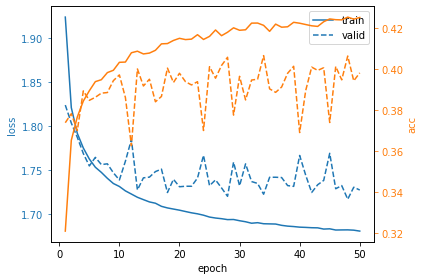

In [21]:
softmax_stats.plot_by_epoch()

In [22]:
softmax_stats.summary()

Epoch 50,loss,acc
train,1.680739,0.4252
valid,1.727351,0.3982


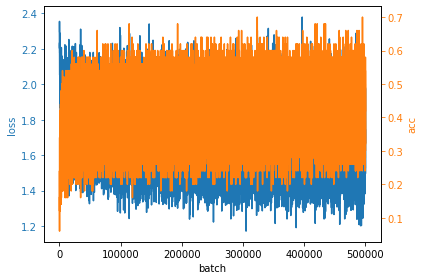

In [23]:
softmax_stats.plot_by_batch(block_len=10)

## Vícevrstvý perceptron

Teď, když máme modularizovanou lineární vrstvu, můžeme si jich vytvořit více a začít je za sebe řetězit. K tomu, abychom vytvořili vícevrstvou síť, však potřebujeme mezi jednotlivé lineární vrstvy ještě přidat nějakou nelineární aktivační funkci. Více lineárních vrstev za sebou totiž dohromady tvoří stále pouze lineární funkci, byť se specifickou faktorizací parametrů.

Nejjednodušší vícevrstvá síť je dvouvrstvý perceptron (perceptron s jednou skrytou vrstvou). Model je:
1. $s_1 = W_1x + b_1$
2. $h = f(x)$
3. $s_2 = W_2h + b_2$

kde $f$ je nějaká nelinearita.

### Sigmoid funkce

Historicky populární volbou nelinearity vycházející z biologického modelu neuronů je sigmoida. Vypadá následovně:


**Dopředný průchod**
$$h = \frac{1}{1 + \exp(-s)}$$

kde $s$ je vstupní "skóre" a $h$ je výsledná skrytá ("hidden") reprezentace.

**Zpětný průchod**
$$\frac{\partial L}{\partial s} = \frac{\partial L}{\partial h} h (1 - h)$$

In [24]:
class Sigmoid(ans.Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, score):
        
        #################################################################
        # ZDE DOPLNIT
        
        hidden = torch.sigmoid(score)
        self._cache = hidden
        
        #################################################################
        
        return hidden
    
    def backward(self, dhidden):
        
        #################################################################
        # ZDE DOPLNIT
        
        hidden = self._cache
        
        dscore = torch.mul(dhidden, torch.mul(hidden, 1-hidden))
        dparams = {}
        
        #################################################################
        
        return dscore, dparams

In [25]:
# overime na male davce
score = torch.randn(10,3)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
dhidden = torch.randn(10,3)

# instance vrstvy
sigmoid_layer = Sigmoid()

# jelikoz sigmoida nema zadne parametry, kontrolovat se bude pouze gradient na vstup
ans.check_gradients(sigmoid_layer, score, dhidden);

dinput1 error:  0.0004263692330874117


### Definice modelu vícevrstvého perceptronu

Celý model složený z více vrstev se bude chovat jako jediná vrstva provádějící komplexnější operaci.

In [26]:
class TwoLayerPerceptron(ans.Layer):
    
    def __init__(self, input_dim, hidden_dim, output_dim, weight_scale=1e-3):
        super().__init__()
        
        #################################################################
        # ZDE DOPLNIT
        
        self.l1 = Linear(input_dim, hidden_dim)
        self.sigm = Sigmoid()
        self.l2 = Linear(hidden_dim, output_dim)
        
        self.params = {
            'weights1': self.l1.params['weights'],
            'bias1': self.l1.params['bias'],
            'weights2': self.l2.params['weights'], 
            'bias2': self.l2.params['bias']
        }
        
        #################################################################
    
    def forward(self, inputs):
        
        #################################################################
        # ZDE DOPLNIT
        
        score = self.l1.forward(inputs)
        sigmoid = self.sigm.forward(score)
        score2 = self.l2.forward(sigmoid)
        
        
        #################################################################

        return score2
    
    def backward(self, dscore2):
        
        #################################################################
        # ZDE DOPLNIT
        
        # backprop po jednotlivych vrstvach postupne zpet az ke vstupu
        
        dhidden, dparams2 = self.l2.backward(dscore2)
        dscore1, dparamss = self.sigm.backward(dhidden)
        dinputs, dparams1 = self.l1.backward(dscore1)
        
        dparams = {
            'weights1': dparams1['weights'],
            'bias1': dparams1['bias'],
            'weights2': dparams2['weights'],
            'bias2': dparams2['bias']
        }
        
        #################################################################
        
        return dinputs, dparams

In [27]:
# overime na male davce
inputs = torch.randn(10,5)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
dscore2 = torch.randn(10,3)

# instance vrstvy
two_layer_perc = TwoLayerPerceptron(5,500,3)

# jelikoz sigmoida nema zadne parametry, kontrolovat se bude pouze gradient na vstup
ans.check_gradients(two_layer_perc, inputs, dscore2);

dinput1 error:  5.894578333772868e-08
dweights1 error:  3.183777145362331e-07
dbias1 error:  6.196038980083817e-07
dweights2 error:  3.5726879816713984e-14
dbias2 error:  3.67414516137693e-13


### Trénování vícevrstvého perceptronu

In [28]:
tlp_model = TwoLayerPerceptron(X_train.shape[1], 50, 10)
sce = SoftmaxCrossEntropy()

train_loader = ans.BatchLoader(X_train, y_train, 10, 'train', shuffle=True)
valid_loader = ans.BatchLoader(X_valid, y_valid, 10, 'valid', shuffle=True)

optimizer = ans.SGD(tlp_model.params, learning_rate=0.02, weight_decay_l2=0.001)

tlp_stats = ans.Stats()

In [29]:
for ep in range(25):
    tlp_stats.new_epoch()
    ans.train(tlp_model, sce, train_loader, optimizer, tlp_stats)
    ans.validate(tlp_model, sce, valid_loader, tlp_stats)

In [30]:
tlp_stats.best_results()

Epoch 24,loss,acc
train,1.563021,0.45038
valid,1.568446,0.45460


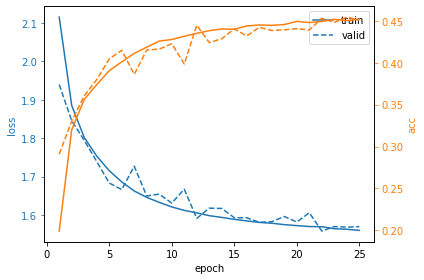

In [31]:
tlp_stats.plot_by_epoch()

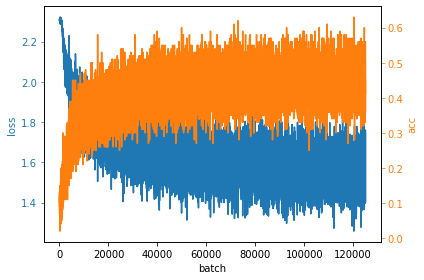

In [32]:
tlp_stats.plot_by_batch(block_len=10)

## Modul: ReLU nelinearita

Sigmoid se z důvodu jeho nevýhodných vlastností pro trénování (především "zabíjení" gradientu při zpětné propagaci) dnes s výjimkou rekurentních sítí již téměř nepoužívá. V současnosti je jednou z nejpopulárnějších nelinearit Recitifed Linear Unit (ReLU), která nuluje vstupy se zápornou hodnotou. Má podobu:

**Dopředný průchod**
$$h = \max(0, s)$$

**Zpětný průchod**
$$\frac{\partial L}{\partial s} = \frac{\partial L}{\partial h} \boldsymbol{1}(s \ge 0)$$

**Poznámka ke gradient checku**

Jelikoz ReLU není diferencovatelná, nemusí si numerický a analytický gradient vždy odpovídat. Chyba vznikne, pokud je ve vstupu $s$ nějaká hodnota blíže nule než je krok $\Delta_s$ pro numerickou diferenci. Např. centrální diference v bodě 0.001 s krokem 0.01 je
$$\frac{ReLU(0.001 + 0.01) - ReLU(0.001 - 0.01)}{2\cdot 0.01} = \frac{0.011 - 0}{0.02} = 0.55$$
zatímco analyticky je derivace v bodě $0.001$ rovna přesně $1$. Je tedy možné, že se občas objeví velká rel. odchylka gradientů, mnohem častěji pro malé hodnoty vstupu $s$. Napravit to lze např. menším krokem $\Delta_s$ numerické diference, který by měl být řádově menší než vstup $s$.

In [38]:
class ReLU(ans.Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, score):
        
        #################################################################
        # ZDE DOPLNIT
        
        hidden = torch.zeros(score.shape)
        hidden = torch.max(hidden, score)
        self._cache = score
        
        #################################################################
        
        return hidden
    
    def backward(self, dhidden):
        
        #################################################################
        # ZDE DOPLNIT
        
        score = self._cache
        dscore = torch.zeros(dhidden.shape)
        dscore[score > 0] = 1
        dparams = {}
        
        #################################################################
        
        return dscore, dparams

In [39]:
# overime na male davce
score = torch.randn(3)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
dhidden = torch.randn(3)

# instance vrstvy
relu_layer = ReLU()

# krok vypoctu numerickeho gradientu nastavime manualne
ans.check_gradients(relu_layer, score, dhidden, h=0.01);

dinput1 error:  0.2648301227739401


# Konfigurovatelný model vícevrstvého perceptronu (bonusová úloha)

Jako bonus navrhněte třídu `FeedForwardNet`, která bude moci mít libovolnou konfiguraci vrstev. Uvažujte pouze jednodušší variantu, kdy vstupem do každé následující vrstvy je výstup vrstvy předchozí. Třída by měla do konstruktoru přijímat pole s vrstvami tak, jak půjdou za sebou v dopředném průchodu. Příklad použití lze vidět v buňce s gradient checkem.

Plně propojené neuronové sítě hlubší než několik málo vrstev dlouhou dobu nedosahovaly výkonnosti jiných metod strojového učení (např. rozhodovací stromy či boosting). Jednou z příčin byla nevhodná inicializace parametrů, díky které aktivace neuronů ve vyšších vrstvách mají nevhodné statistické rozložení (viz přednášku) a zpětná propagace gradientu je pak velice obtížná. Pokud síť projde gradient checkem, ale přesto se z dat neučí, hlavním podezřelým bude nejspíše právě inicializace. Pro úspěšné trénování je proto dobré implementovat `xavier` inicializaci ve vrstvě `Linear`.

In [ ]:
class FeedForwardNet(ans.Layer):
    def __init__(self, layers):
        super().__init__()
        
        self.layers = layers
        self.params = {}
        
        #################################################################
        # ZDE DOPLNIT
        
        # dynamicky z predanych vrstev naplnit slovnik parametru,
        # analogicky k postupu z TwoLayerPerceptron
        ...
        
        #################################################################
    
    def forward(self, inputs):
        
        #################################################################
        # ZDE DOPLNIT
        
        # dopredny pruchod je jednoduchy, jen se jednotlive vrstvy zavolaji
        # tak, jak jdou za sebou
            
        #################################################################
        
        return score
    
    def backward(self, dscore):
        
        #################################################################
        # ZDE DOPLNIT
        
        # vrstvy se musi projit v obracenem poradi a postupne volat jejich
        # zpetne pruchody, dokud nedojdeme az zpet na vstup
        
        #################################################################
        
        return dinputs, dparams

In [ ]:
inputs = torch.randn(10, 8)
dscore = torch.randn(10, 3)
relu_layer = FeedForwardNet([
    Linear(8, 6),
    Sigmoid(),
    Linear(6, 5),
    Sigmoid(),
    Linear(5, 3)
])
ans.check_gradients(relu_layer, inputs, dscore);

In [ ]:
mlp_model = FeedForwardNet([
    Linear(...),
    ReLU(),
    Linear(...),
    ReLU(),
    Linear(...)
    # libovolne lze pokracovat
])

sce = SoftmaxCrossEntropy()

train_loader = ans.BatchLoader(X_train, y_train, ..., 'train', shuffle=True)
valid_loader = ans.BatchLoader(X_valid, y_valid, ..., 'valid', shuffle=True)

optimizer = ans.SGD(mlp_model.params, learning_rate=..., weight_decay_l2=...)

mlp_stats = ans.Stats()

In [ ]:
for ep in range(2):
    mlp_stats.new_epoch()
    ans.train(mlp_model, sce, train_loader, optimizer, mlp_stats)
    ans.validate(mlp_model, sce, valid_loader, mlp_stats)

In [ ]:
mlp_stats.best_results()

In [ ]:
mlp_stats.plot_by_epoch()

In [ ]:
mlp_stats.plot_by_batch(block_len=10)